In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class
class PaddyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with image info.
            root_dir (string): Directory with all the images, organized by disease.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the metadata CSV
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Create mappings for disease labels (string to numeric)
        self.disease_name_to_label = {disease: idx for idx, disease in enumerate(self.data['label'].unique())}
        
        # Create a mapping for variety (string to numeric, optional depending on use)
        self.variety_name_to_label = {variety: idx for idx, variety in enumerate(self.data['variety'].unique())}
        
        # Store reverse mappings for human-readable output
        self.label_to_disease_name = {v: k for k, v in self.disease_name_to_label.items()}
        self.label_to_variety_name = {v: k for k, v in self.variety_name_to_label.items()}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the image filename and corresponding labels
        image_id = self.data.iloc[idx, 0]  # Image filename like '100330.jpg'
        disease_name = self.data.iloc[idx, 1]  # Disease name like 'bacterial_leaf_blight'
        variety_name = self.data.iloc[idx, 2]  # Variety name like 'ADT45'
        age = self.data.iloc[idx, 3]  # Age value (numeric)
        
        # Convert disease name and variety name to numeric labels
        disease_label = self.disease_name_to_label[disease_name]
        variety_label = self.variety_name_to_label[variety_name]
        
        # Construct the image path (keep disease name as folder name)
        img_path = os.path.join(self.root_dir, disease_name, image_id)
        
        # Load the image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        # Return the image and labels as tensors
        return image, torch.tensor(disease_label, dtype=torch.long), torch.tensor(variety_label, dtype=torch.long), torch.tensor(age, dtype=torch.float32)

# Function to map numeric predictions back to readable disease and variety names
def map_predictions_to_human_readable(predictions, dataset):
    disease_predictions = [dataset.label_to_disease_name[pred[0].item()] for pred in predictions]
    variety_predictions = [dataset.label_to_variety_name[pred[1].item()] for pred in predictions]
    return disease_predictions, variety_predictions

# Function to map predictions to human-readable disease names
def map_predictions_to_disease_name(predictions, dataset):
    # Convert numeric predictions to disease names using the reverse mapping
    return [dataset.label_to_disease_name[pred] for pred in predictions]

# Load data
csv_file = "/kaggle/input/dataset-review-ii/train.csv"
root_dir = "/kaggle/input/dataset-review-ii/train_images"
data_df = pd.read_csv(csv_file)

num_varieties = data_df["variety"].nunique()

# Split dataset
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)
print("Dataset split completed.")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
datasets = {
    'train': PaddyDataset("train.csv", root_dir, transform),
    'val': PaddyDataset("val.csv", root_dir, transform),
    'test': PaddyDataset("test.csv", root_dir, transform)
}

dataloaders = {x: DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
print("Dataloaders created.")

# Multi-task Vision Transformer Model
class ViTMultiTask(nn.Module):
    def __init__(self, num_diseases=10, num_varieties=num_varieties):
        super(ViTMultiTask, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()  # Remove the original classification head
        
        self.disease_head = nn.Linear(768, num_diseases)
        self.variety_head = nn.Linear(768, num_varieties)
        self.age_head = nn.Linear(768, 1)  # Regression output
        
    def forward(self, x):
        features = self.vit(x)
        disease_pred = self.disease_head(features)
        variety_pred = self.variety_head(features)
        age_pred = self.age_head(features)
        return disease_pred, variety_pred, age_pred

model = ViTMultiTask().to(device)
print("Model loaded.")

# Loss functions
criterion_disease = nn.CrossEntropyLoss()
criterion_variety = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
scaler = GradScaler()  # Mixed precision training

# Training function
def train_model(model, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0
            
            for inputs, labels_disease, labels_variety, labels_age in dataloaders[phase]:
                inputs, labels_disease, labels_variety, labels_age = inputs.to(device), labels_disease.to(device), labels_variety.to(device), labels_age.to(device)
                
                optimizer.zero_grad()
                
                # Mixed Precision Training
                if torch.cuda.is_available():
                    # Use autocast for mixed precision on GPU
                    with autocast():
                        preds_disease, preds_variety, preds_age = model(inputs)
                        loss_disease = criterion_disease(preds_disease, labels_disease)
                        loss_variety = criterion_variety(preds_variety, labels_variety)
                        loss_age = criterion_age(preds_age.squeeze(), labels_age)
                        loss = loss_disease + loss_variety + loss_age
                else:
                    # Use autocast for mixed precision on CPU
                    with autocast():
                        preds_disease, preds_variety, preds_age = model(inputs)
                        loss_disease = criterion_disease(preds_disease, labels_disease)
                        loss_variety = criterion_variety(preds_variety, labels_variety)
                        loss_age = criterion_age(preds_age.squeeze(), labels_age)
                        loss = loss_disease + loss_variety + loss_age
                
                if phase == 'train':
                    # Scale the loss and backpropagate
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                # Calculate accuracy for disease classification
                _, predicted_disease = torch.max(preds_disease, 1)
                correct_preds += (predicted_disease == labels_disease).sum().item()
                total_preds += labels_disease.size(0)
                
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = correct_preds / total_preds * 100
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(epoch_accuracy)
            
            print(f"{phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
        scheduler.step(epoch_loss)
    
    print("Training complete.")
    return history

# Train the model
history = train_model(model, num_epochs=10)

# Save the trained model
torch.save(model.state_dict(), "vit_paddy_multitask.pth")
print("Model saved.")

# Plot training & validation loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.show()

# Generate predictions
def predict_and_save(model, dataloader, filename="predictions.csv"):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for inputs, _, _, _ in dataloader:
            inputs = inputs.to(device)
            preds_disease, preds_variety, preds_age = model(inputs)
            
            disease_preds = torch.argmax(preds_disease, dim=1).cpu().numpy()
            variety_preds = torch.argmax(preds_variety, dim=1).cpu().numpy()
            age_preds = preds_age.cpu().numpy().squeeze()
            
            for i in range(len(disease_preds)):
                predictions.append([disease_preds[i], variety_preds[i], age_preds[i]])
    
    df = pd.DataFrame(predictions, columns=['Predicted_Disease', 'Predicted_Variety', 'Predicted_Age'])
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

# Save test predictions
predict_and_save(model, dataloaders['test'])

print("Complete.")


Using device: cuda
Dataset split completed.
Dataloaders created.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 101MB/s]  


Model loaded.
Epoch 1/10


<ipython-input-2-f8c0eba2b9e3>:149: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training
<ipython-input-2-f8c0eba2b9e3>:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class
class PaddyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.disease_name_to_label = {disease: idx for idx, disease in enumerate(self.data['label'].unique())}
        self.variety_name_to_label = {variety: idx for idx, variety in enumerate(self.data['variety'].unique())}
        self.label_to_disease_name = {v: k for k, v in self.disease_name_to_label.items()}
        self.label_to_variety_name = {v: k for k, v in self.variety_name_to_label.items()}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_id = self.data.iloc[idx, 0]
        disease_name = self.data.iloc[idx, 1]
        variety_name = self.data.iloc[idx, 2]
        age = self.data.iloc[idx, 3]
        
        disease_label = self.disease_name_to_label[disease_name]
        variety_label = self.variety_name_to_label[variety_name]
        
        img_path = os.path.join(self.root_dir, disease_name, image_id)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(disease_label, dtype=torch.long), torch.tensor(variety_label, dtype=torch.long), torch.tensor(age, dtype=torch.float32)

# Mapping predictions back to human-readable labels
def map_predictions_to_human_readable(predictions, dataset):
    disease_predictions = [dataset.label_to_disease_name[pred[0].item()] for pred in predictions]
    variety_predictions = [dataset.label_to_variety_name[pred[1].item()] for pred in predictions]
    return disease_predictions, variety_predictions

# Load dataset and create splits
csv_file = "/kaggle/input/dataset-review-ii/train.csv"
root_dir = "/kaggle/input/dataset-review-ii/train_images"
data_df = pd.read_csv(csv_file)

# Split dataset into train, validation, and test
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)
print("Dataset split completed.")

# Image transformations with additional augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
datasets = {
    'train': PaddyDataset("train.csv", root_dir, transform),
    'val': PaddyDataset("val.csv", root_dir, transform),
    'test': PaddyDataset("test.csv", root_dir, transform)
}

dataloaders = {x: DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
print("Dataloaders created.")

# Multi-task Vision Transformer (ViT) Model
class ViTMultiTask(nn.Module):
    def __init__(self, num_diseases=10, num_varieties=12):
        super(ViTMultiTask, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()  # Remove original classification head
        
        self.disease_head = nn.Linear(768, num_diseases)
        self.variety_head = nn.Linear(768, num_varieties)
        self.age_head = nn.Linear(768, 1)  # Regression output for age
    
    def forward(self, x):
        features = self.vit(x)
        disease_pred = self.disease_head(features)
        variety_pred = self.variety_head(features)
        age_pred = self.age_head(features)
        return disease_pred, variety_pred, age_pred

# Initialize model
model = ViTMultiTask().to(device)
print("Model loaded.")

# Loss functions
criterion_disease = nn.CrossEntropyLoss()
criterion_variety = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
scaler = GradScaler()  # Mixed precision training

# Training function
def train_model(model, num_epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_preds': [], 'val_preds': [], 'train_labels': [], 'val_labels': []}
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0
            all_preds = []
            all_labels = []
            
            for inputs, labels_disease, labels_variety, labels_age in dataloaders[phase]:
                inputs, labels_disease, labels_variety, labels_age = inputs.to(device), labels_disease.to(device), labels_variety.to(device), labels_age.to(device)
                
                optimizer.zero_grad()
                
                # Mixed Precision Training
                with autocast():
                    preds_disease, preds_variety, preds_age = model(inputs)
                    loss_disease = criterion_disease(preds_disease, labels_disease)
                    loss_variety = criterion_variety(preds_variety, labels_variety)
                    loss_age = criterion_age(preds_age.squeeze(), labels_age)
                    loss = loss_disease + loss_variety + loss_age
                
                if phase == 'train':
                    # Scale the loss and backpropagate
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                # Calculate accuracy for disease classification
                _, predicted_disease = torch.max(preds_disease, 1)
                correct_preds += (predicted_disease == labels_disease).sum().item()
                total_preds += labels_disease.size(0)
                
                running_loss += loss.item() * inputs.size(0)
                
                all_preds.extend(predicted_disease.cpu().numpy())
                all_labels.extend(labels_disease.cpu().numpy())
            
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = correct_preds / total_preds * 100
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(epoch_accuracy)
            history[f'{phase}_preds'].append(all_preds)
            history[f'{phase}_labels'].append(all_labels)
            
            print(f"{phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
        scheduler.step(epoch_loss)
    
    print("Training complete.")
    return history

# Train the model
history = train_model(model, num_epochs=25)

# Save the trained model
torch.save(model.state_dict(), "vit_paddy_multitask.pth")
print("Model saved.")

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")

plt.tight_layout()
plt.show()

# Confusion Matrix
def plot_confusion_matrix(predictions, labels, num_classes, class_names):
    cm = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Collect all predictions and labels from the validation set
all_val_preds = np.concatenate(history['val_preds'])
all_val_labels = np.concatenate(history['val_labels'])

# Get class names
class_names = list(datasets['train'].disease_name_to_label.keys())

# Plot the confusion matrix for disease classification
plot_confusion_matrix(all_val_preds, all_val_labels, len(class_names), class_names)

# Generate predictions
def predict_and_save(model, dataloader, filename="predictions.csv"):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for inputs, _, _, _ in dataloaders['test']:
            inputs = inputs.to(device)
            preds_disease, preds_variety, preds_age = model(inputs)
            
            disease_preds = torch.argmax(preds_disease, dim=1).cpu().numpy()
            variety_preds = torch.argmax(preds_variety, dim=1).cpu().numpy()
            age_preds = preds_age.cpu().numpy().squeeze()
            
            for i in range(len(disease_preds)):
                predictions.append([disease_preds[i], variety_preds[i], age_preds[i]])
    
    df = pd.DataFrame(predictions, columns=['Predicted_Disease', 'Predicted_Variety', 'Predicted_Age'])
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

# Save test predictions
predict_and_save(model, dataloaders['test'])


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PaddyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Encode labels
        self.disease_name_to_label = {disease: idx for idx, disease in enumerate(self.data['label'].unique())}
        self.variety_name_to_label = {variety: idx for idx, variety in enumerate(self.data['variety'].unique())}
        
        self.label_to_disease_name = {v: k for k, v in self.disease_name_to_label.items()}
        self.label_to_variety_name = {v: k for k, v in self.variety_name_to_label.items()}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_id = self.data.iloc[idx, 0]  
        disease_name = self.data.iloc[idx, 1]
        variety_name = self.data.iloc[idx, 2]
        age = self.data.iloc[idx, 3]  

        disease_label = self.disease_name_to_label[disease_name]
        variety_label = self.variety_name_to_label[variety_name]
        
        img_path = os.path.join(self.root_dir, disease_name, image_id)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(disease_label, dtype=torch.long), torch.tensor(variety_label, dtype=torch.long), torch.tensor(age, dtype=torch.float32)

csv_file = "/kaggle/input/dataset-review-ii/train.csv"
root_dir = "/kaggle/input/dataset-review-ii/train_images"

data_df = pd.read_csv(csv_file)

num_varieties = data_df["variety"].nunique()
num_diseases = data_df["label"].nunique()

# Split dataset
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
datasets = {
    'train': PaddyDataset("train.csv", root_dir, transform),
    'val': PaddyDataset("val.csv", root_dir, transform),
    'test': PaddyDataset("test.csv", root_dir, transform)
}

dataloaders = {x: DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

class ViTMultiTask(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super(ViTMultiTask, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()  
        
        self.dropout = nn.Dropout(0.3)  
        self.disease_head = nn.Linear(768, num_diseases)
        self.variety_head = nn.Linear(768, num_varieties)
        self.age_head = nn.Linear(768, 1)  
        
    def forward(self, x):
        features = self.vit(x)
        features = self.dropout(features)
        return self.disease_head(features), self.variety_head(features), self.age_head(features)

model = ViTMultiTask(num_diseases, num_varieties).to(device)

criterion_disease = nn.CrossEntropyLoss()
criterion_variety = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
scaler = GradScaler()

def train_model(model, num_epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0
            
            for inputs, labels_disease, labels_variety, labels_age in dataloaders[phase]:
                inputs, labels_disease, labels_variety, labels_age = inputs.to(device), labels_disease.to(device), labels_variety.to(device), labels_age.to(device)
                
                optimizer.zero_grad()
                
                with autocast():
                    preds_disease, preds_variety, preds_age = model(inputs)
                    loss_disease = criterion_disease(preds_disease, labels_disease)
                    loss_variety = criterion_variety(preds_variety, labels_variety)
                    loss_age = criterion_age(preds_age.squeeze(), labels_age)
                    loss = loss_disease + loss_variety + loss_age
                
                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                _, predicted_disease = torch.max(preds_disease, 1)
                correct_preds += (predicted_disease == labels_disease).sum().item()
                total_preds += labels_disease.size(0)
                
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = correct_preds / total_preds * 100
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(epoch_accuracy)
            
            print(f"{phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
        scheduler.step(epoch_loss)
    
    return history

history = train_model(model, num_epochs=25)

plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class PaddyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        self.disease_name_to_label = {disease: idx for idx, disease in enumerate(self.data['label'].unique())}
        self.variety_name_to_label = {variety: idx for idx, variety in enumerate(self.data['variety'].unique())}
        
        self.label_to_disease_name = {v: k for k, v in self.disease_name_to_label.items()}
        self.label_to_variety_name = {v: k for k, v in self.variety_name_to_label.items()}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_id = self.data.iloc[idx, 0]  
        disease_name = self.data.iloc[idx, 1]
        variety_name = self.data.iloc[idx, 2]
        age = self.data.iloc[idx, 3]  

        disease_label = self.disease_name_to_label[disease_name]
        variety_label = self.variety_name_to_label[variety_name]
        
        img_path = os.path.join(self.root_dir, disease_name, image_id)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(disease_label, dtype=torch.long), torch.tensor(variety_label, dtype=torch.long), torch.tensor(age, dtype=torch.float32)

# Paths
csv_file = "/kaggle/input/dataset-review-ii/train.csv"
root_dir = "/kaggle/input/dataset-review-ii/train_images"

data_df = pd.read_csv(csv_file)

num_varieties = data_df["variety"].nunique()
num_diseases = data_df["label"].nunique()

# Split dataset
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
datasets = {
    'train': PaddyDataset("train.csv", root_dir, transform),
    'val': PaddyDataset("val.csv", root_dir, transform),
    'test': PaddyDataset("test.csv", root_dir, transform)
}

dataloaders = {x: DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Define ViT Multi-Task Model
class ViTMultiTask(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super(ViTMultiTask, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()  
        
        self.dropout = nn.Dropout(0.3)  
        self.disease_head = nn.Linear(768, num_diseases)
        self.variety_head = nn.Linear(768, num_varieties)
        self.age_head = nn.Linear(768, 1)  
        
    def forward(self, x):
        features = self.vit(x)
        features = self.dropout(features)
        return self.disease_head(features), self.variety_head(features), self.age_head(features)

model = ViTMultiTask(num_diseases, num_varieties).to(device)

# Loss functions
criterion_disease = nn.CrossEntropyLoss()
criterion_variety = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

# Optimizer and Learning Rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2)
scaler = GradScaler()

# Training Function
def train_model(model, num_epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            
            running_loss, correct_preds, total_preds = 0.0, 0, 0
            
            for inputs, labels_disease, labels_variety, labels_age in dataloaders[phase]:
                inputs, labels_disease, labels_variety, labels_age = inputs.to(device), labels_disease.to(device), labels_variety.to(device), labels_age.to(device)
                
                optimizer.zero_grad()
                
                with autocast():
                    preds_disease, preds_variety, preds_age = model(inputs)
                    loss_disease = criterion_disease(preds_disease, labels_disease)
                    loss_variety = criterion_variety(preds_variety, labels_variety)
                    loss_age = criterion_age(preds_age.squeeze(), labels_age)
                    loss = loss_disease + loss_variety + loss_age
                
                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                _, predicted_disease = torch.max(preds_disease, 1)
                correct_preds += (predicted_disease == labels_disease).sum().item()
                total_preds += labels_disease.size(0)
                
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = correct_preds / total_preds * 100
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(epoch_accuracy)
            
            print(f"{phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
        scheduler.step(epoch_loss)
    
    return history

# Train the model
history = train_model(model, num_epochs=25)

# Save Model
torch.save(model.state_dict(), "ViT_Paddy_Classification03/01.pth")

# Plot Accuracy and Loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# **ROC Curve**
def plot_roc(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    print(f"ROC AUC Score: {roc_auc:.2f}")

image_path = "/kaggle/input/test-image/100017.jpg"
# **Manual Image Testing**
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
    return outputs


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
from transformers import get_cosine_schedule_with_warmup
from torchvision.models.vision_transformer import ViT_B_16_Weights

import warnings
warnings.filterwarnings("ignore")

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Paddy Dataset Class
class PaddyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.disease_name_to_label = {disease: idx for idx, disease in enumerate(self.data['label'].unique())}
        self.variety_name_to_label = {variety: idx for idx, variety in enumerate(self.data['variety'].unique())}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_id = self.data.iloc[idx, 0]
        disease_name = self.data.iloc[idx, 1]
        variety_name = self.data.iloc[idx, 2]
        age = self.data.iloc[idx, 3]

        disease_label = self.disease_name_to_label[disease_name]
        variety_label = self.variety_name_to_label[variety_name]

        img_path = os.path.join(self.root_dir, disease_name, image_id)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(disease_label), torch.tensor(variety_label), torch.tensor(age, dtype=torch.float32)

# ✅ Load & Split Data
csv_file = "/kaggle/input/dataset-review-ii/train.csv"
root_dir = "/kaggle/input/dataset-review-ii/train_images"

data_df = pd.read_csv(csv_file)
num_varieties = data_df["variety"].nunique()
num_diseases = data_df["label"].nunique()

train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

# ✅ Advanced Image Augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load Datasets
datasets = {
    'train': PaddyDataset("train.csv", root_dir, transform),
    'val': PaddyDataset("val.csv", root_dir, transform),
    'test': PaddyDataset("test.csv", root_dir, transform)
}

dataloaders = {x: DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# ✅ ViT Model for Multi-Task Learning
class ViTMultiTask(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super(ViTMultiTask, self).__init__()
        self.vit = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        num_ftrs = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, 768)
        )
        self.dropout = nn.Dropout(0.3)
        self.disease_head = nn.Linear(768, num_diseases)
        self.variety_head = nn.Linear(768, num_varieties)
        self.age_head = nn.Linear(768, 1)

    def forward(self, x):
        features = self.vit(x)
        features = self.dropout(features)
        return self.disease_head(features), self.variety_head(features), self.age_head(features)

# ✅ Initialize Model
model = ViTMultiTask(num_diseases, num_varieties).to(device)

# ✅ Loss Functions
criterion_disease = nn.CrossEntropyLoss()
criterion_variety = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

# ✅ Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# ✅ Training Function
def train_model(model, num_epochs=25):
    print("\n🚀 Training Started 🚀\n")
    
    for epoch in range(num_epochs):
        print(f"📌 Epoch {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            correct_preds = 0
            total_preds = 0

            for inputs, labels_disease, labels_variety, labels_age in dataloaders[phase]:
                inputs, labels_disease, labels_variety, labels_age = (
                    inputs.to(device), labels_disease.to(device),
                    labels_variety.to(device), labels_age.to(device)
                )

                optimizer.zero_grad()
                with autocast():
                    preds_disease, preds_variety, preds_age = model(inputs)
                    loss = (
                        criterion_disease(preds_disease, labels_disease)
                        + criterion_variety(preds_variety, labels_variety)
                        + criterion_age(preds_age.squeeze(), labels_age)
                    )

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                correct_preds += (preds_disease.argmax(1) == labels_disease).sum().item()
                total_preds += labels_disease.size(0)
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = correct_preds / total_preds * 100

            if phase == 'val':
                print(f"   🔹 VAL Loss: {epoch_loss:.4f}  |  Accuracy: {epoch_acc:.2f}%")
            else:
                print(f"   🔹 TRAIN Loss: {epoch_loss:.4f}  |  Accuracy: {epoch_acc:.2f}%")

        scheduler.step(correct_preds / total_preds)

    print("\n✅ Training Completed!\n")
    torch.save(model.state_dict(), "vit_paddy_model0401.pth")
    
def test_single_image(model, image_path, transform):
    model.eval()
    image = transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    
    with torch.no_grad():
        preds_disease, preds_variety, preds_age = model(image)

    predicted_disease = preds_disease.argmax().item()
    predicted_variety = preds_variety.argmax().item()
    predicted_age = preds_age.item()

    print("\n🔍 **Manual Image Prediction** 🔍")
    print(f"📌 Image: {os.path.basename(image_path)}")
    print(f"   🦠 Disease: {predicted_disease}")
    print(f"   🌱 Variety: {predicted_variety}")
    print(f"   📏 Estimated Age: {predicted_age:.2f} days\n")
# ✅ Train the model
train_model(model, num_epochs=25)

# ✅ Test a single image
image_path = "/kaggle/input/test-image/100017.jpg"
test_single_image(model, image_path, transform)


In [ ]:
# ✅ Full Code: ViT Multi-Task Learning for Paddy Leaf Classification

import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models.vision_transformer import ViT_B_16_Weights
from torch.cuda.amp import autocast
import warnings


warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, target):
        logprobs = self.log_softmax(x)
        with torch.no_grad():
            true_dist = torch.zeros_like(logprobs)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * logprobs, dim=-1))

class PaddyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.disease_name_to_label = {disease: idx for idx, disease in enumerate(self.data['label'].unique())}
        self.variety_name_to_label = {variety: idx for idx, variety in enumerate(self.data['variety'].unique())}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_id, disease_name, variety_name, age = row['image_id'], row['label'], row['variety'], row['age']
        disease_label = self.disease_name_to_label[disease_name]
        variety_label = self.variety_name_to_label[variety_name]
        img_path = os.path.join(self.root_dir, disease_name, image_id)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(disease_label), torch.tensor(variety_label), torch.tensor(age, dtype=torch.float32)

# Data Loading
csv_file = "/kaggle/input/dataset-review-ii/train.csv"
root_dir = "/kaggle/input/dataset-review-ii/train_images"
data_df = pd.read_csv(csv_file)

train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

num_varieties = data_df["variety"].nunique()
num_diseases = data_df["label"].nunique()

# Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

datasets = {
    'train': PaddyDataset("train.csv", root_dir, transform),
    'val': PaddyDataset("val.csv", root_dir, transform),
    'test': PaddyDataset("test.csv", root_dir, transform)
}
dataloaders = {
    x: DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

class ViTMultiTask(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super(ViTMultiTask, self).__init__()
        self.vit = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        num_ftrs = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, 768)
        )
        self.dropout = nn.Dropout(0.3)
        self.disease_head = nn.Linear(768, num_diseases)
        self.variety_head = nn.Linear(768, num_varieties)
        self.age_head = nn.Linear(768, 1)

    def forward(self, x):
        features = self.vit(x)
        features = self.dropout(features)
        return self.disease_head(features), self.variety_head(features), self.age_head(features)

model = ViTMultiTask(num_diseases, num_varieties).to(device)

criterion_disease = LabelSmoothingLoss(num_diseases, smoothing=0.1)
criterion_variety = LabelSmoothingLoss(num_varieties, smoothing=0.1)
criterion_age = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

def train_model(model, num_epochs=25):
    print("🚀 Training Started 🚀\n")
    for epoch in range(num_epochs):
        print(f"📌 Epoch {epoch + 1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_disease_loss, running_variety_loss, running_age_loss = 0.0, 0.0, 0.0, 0.0
            correct_disease, correct_variety, total_samples = 0, 0, 0

            for inputs, labels_disease, labels_variety, labels_age in dataloaders[phase]:
                inputs = inputs.to(device)
                labels_disease = labels_disease.to(device)
                labels_variety = labels_variety.to(device)
                labels_age = labels_age.to(device)

                optimizer.zero_grad()
                with autocast():
                    out_disease, out_variety, out_age = model(inputs)

                    loss_disease = criterion_disease(out_disease, labels_disease)
                    loss_variety = criterion_variety(out_variety, labels_variety)
                    loss_age = criterion_age(out_age.squeeze(), labels_age)

                    loss = loss_disease + loss_variety + loss_age

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                correct_disease += (out_disease.argmax(1) == labels_disease).sum().item()
                correct_variety += (out_variety.argmax(1) == labels_variety).sum().item()
                total_samples += labels_disease.size(0)

                running_loss += loss.item() * inputs.size(0)
                running_disease_loss += loss_disease.item() * inputs.size(0)
                running_variety_loss += loss_variety.item() * inputs.size(0)
                running_age_loss += loss_age.item() * inputs.size(0)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_disease_loss = running_disease_loss / len(datasets[phase])
            epoch_variety_loss = running_variety_loss / len(datasets[phase])
            epoch_age_loss = running_age_loss / len(datasets[phase])
            acc_disease = correct_disease / total_samples * 100
            acc_variety = correct_variety / total_samples * 100

            print(f"   🔹 {phase.upper()} Loss: {epoch_loss:.4f} (Disease: {epoch_disease_loss:.2f}, Variety: {epoch_variety_loss:.2f}, Age: {epoch_age_loss:.2f})")
            print(f"     🎯 Accuracy - Disease: {acc_disease:.2f}%, Variety: {acc_variety:.2f}%")

            if phase == 'val':
                scheduler.step(acc_disease)
    print("\n✅ Training Completed!")


def test_single_image(model, image_path, transform):
    model.eval()
    image = transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    T = 0.5
    confidence_threshold = 50
    with torch.no_grad():
        out_disease, out_variety, out_age = model(image)
        probs = F.softmax(out_disease / T, dim=1).cpu().numpy()
        predicted_class = np.argmax(probs)
        confidence = probs[0][predicted_class] * 100

        if confidence < confidence_threshold:
            print(f"⚠️ Low confidence ({confidence:.2f}%), skipping this image.")
            return
        print("\\n🔍 **Manual Image Prediction** 🔍")
        print(f"📌 Image: {os.path.basename(image_path)}")
        print(f"   🦠 Disease: {predicted_class}")
        print(f"   🌱 Variety: {out_variety.argmax().item()}")
        print(f"   📏 Estimated Age: {out_age.item():.2f} days")

# ✅ Train the model
train_model(model, num_epochs=25)

# ✅ Test on a sample image
image_path = "/kaggle/input/test-image/100017.jpg"
test_single_image(model, image_path, transform)


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

csv_file = "/kaggle/input/dataset-review-ii/train.csv"
image_root = "/kaggle/input/dataset-review-ii/train_images"

df = pd.read_csv(csv_file)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

label2idx = {label: idx for idx, label in enumerate(df['label'].unique())}
variety2idx = {variety: idx for idx, variety in enumerate(df['variety'].unique())}
num_diseases = len(label2idx)
num_varieties = len(variety2idx)

class PaddyDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.label2idx = label2idx
        self.variety2idx = variety2idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["label"], row["image_id"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.label2idx[row["label"]]
        variety = self.variety2idx[row["variety"]]
        age = float(row["age"])

        return image, torch.tensor(label), torch.tensor(variety), torch.tensor(age, dtype=torch.float32)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = PaddyDataset(train_df, image_root, transform)
val_dataset = PaddyDataset(val_df, image_root, transform)
test_dataset = PaddyDataset(test_df, image_root, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class ResNetMultiTask(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super().__init__()
        self.base = models.resnet50(pretrained=True)
        in_features = self.base.fc.in_features
        self.base.fc = nn.Identity()

        self.fc_common = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fc_disease = nn.Linear(512, num_diseases)
        self.fc_variety = nn.Linear(512, num_varieties)
        self.fc_age = nn.Linear(512, 1)

    def forward(self, x):
        features = self.base(x)
        x = self.fc_common(features)
        return self.fc_disease(x), self.fc_variety(x), self.fc_age(x)

model = ResNetMultiTask(num_diseases, num_varieties).to(device)

criterion_cls = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

def train_model(model, num_epochs=25):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"\n📍 Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels, varieties, ages in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                varieties, ages = varieties.to(device), ages.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs_label, outputs_variety, outputs_age = model(inputs)

                    loss_label = criterion_cls(outputs_label, labels)
                    loss_variety = criterion_cls(outputs_variety, varieties)
                    loss_age = criterion_age(outputs_age.squeeze(), ages)

                    loss = loss_label + loss_variety + loss_age

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                _, preds = torch.max(outputs_label, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f"   🔹 {phase.upper()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(), "best_resnet_multitask.pth")
                    print("✅ Best model saved.")

    return history

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels, _, _ in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, _, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n📊 Accuracy: {acc:.4f} | Recall: {rec:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2idx.keys()))
    disp.plot(xticks_rotation=90, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

history = train_model(model, num_epochs=25)
evaluate_model(model, test_loader)

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)



In [ ]:
import pandas as pd
df = pd.read_csv("train.csv")
print(df['label'].value_counts())


In [ ]:
# Unifying the complete code with:
# - ResNet model
# - Multi-task learning: Disease (10 classes), Variety, Age
# - Class balancing with WeightedRandomSampler
# - Training & validation
# - Metrics: Accuracy, Recall, Specificity, Confusion Matrix
# - ROC Curve
# - Final prediction and CSV saving

import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms

# Path setup (for Kaggle)
csv_file = "/kaggle/input/dataset-review-ii/train.csv"
root_dir = "/kaggle/input/dataset-review-ii/train_images"

# Dataset
class PaddyDataset(Dataset):
    def __init__(self, df, root_dir, disease2idx, variety2idx, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.disease2idx = disease2idx
        self.variety2idx = variety2idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        disease = self.disease2idx[row['label']]
        variety = self.variety2idx[row['variety']]
        age = float(row['age'])

        image_path = os.path.join(self.root_dir, row['label'], image_id)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(disease), torch.tensor(variety), torch.tensor(age, dtype=torch.float32)

# Data and transforms
df = pd.read_csv(csv_file)
disease2idx = {cls: idx for idx, cls in enumerate(df['label'].unique())}
variety2idx = {cls: idx for idx, cls in enumerate(df['variety'].unique())}
idx2disease = {v: k for k, v in disease2idx.items()}
idx2variety = {v: k for k, v in variety2idx.items()}

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Compute class weights
class_counts = train_df['label'].value_counts().sort_index()
class_weights = 1.0 / class_counts
train_df['weight'] = train_df['label'].map(class_weights)
sample_weights = train_df['weight'].values
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Loaders
train_dataset = PaddyDataset(train_df, root_dir, disease2idx, variety2idx, transform)
val_dataset = PaddyDataset(val_df, root_dir, disease2idx, variety2idx, transform)
test_dataset = PaddyDataset(test_df, root_dir, disease2idx, variety2idx, transform)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model
class ResNetMultiTask(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super(ResNetMultiTask, self).__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = base_model.fc.in_features
        base_model.fc = nn.Identity()
        self.base = base_model
        self.dropout = nn.Dropout(0.3)
        self.disease_head = nn.Linear(in_features, num_diseases)
        self.variety_head = nn.Linear(in_features, num_varieties)
        self.age_head = nn.Linear(in_features, 1)

    def forward(self, x):
        features = self.base(x)
        features = self.dropout(features)
        return self.disease_head(features), self.variety_head(features), self.age_head(features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetMultiTask(len(disease2idx), len(variety2idx)).to(device)

# Loss and optimizer
criterion_disease = nn.CrossEntropyLoss()
criterion_variety = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Train function
train_loss_list, val_loss_list = [], []

def train(model, num_epochs=25):
    for epoch in range(num_epochs):
        print(f"\n📌 Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss, correct_disease, total = 0.0, 0, 0

            for inputs, labels_disease, labels_variety, labels_age in dataloader:
                inputs = inputs.to(device)
                labels_disease = labels_disease.to(device)
                labels_variety = labels_variety.to(device)
                labels_age = labels_age.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    out_disease, out_variety, out_age = model(inputs)
                    loss = (criterion_disease(out_disease, labels_disease) +
                            criterion_variety(out_variety, labels_variety) +
                            criterion_age(out_age.squeeze(), labels_age))
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_disease += (out_disease.argmax(1) == labels_disease).sum().item()
                total += labels_disease.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct_disease / total * 100
            print(f"   🔹 {phase.upper()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")
            if phase == 'train':
                train_loss_list.append(epoch_loss)
            else:
                val_loss_list.append(epoch_loss)
                scheduler.step(epoch_acc)

    print("\n✅ Training Completed.")

train(model)

# Save model
torch.save(model.state_dict(), "resnet_paddy_model.pth")




In [ ]:
# Full Multi-Task Vision Transformer Training Pipeline with Evaluation and Visualization
# Tasks: Disease Classification, Variety Classification, Age Regression

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, recall_score, precision_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

from tqdm import tqdm
import seaborn as sns
import joblib

# === Dataset ===
class PaddyDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        self.label_encoder = LabelEncoder()
        self.variety_encoder = LabelEncoder()

        self.data['label_idx'] = self.label_encoder.fit_transform(self.data['label'])
        self.data['variety_idx'] = self.variety_encoder.fit_transform(self.data['variety'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Construct full image path assuming images are in subfolders named after disease labels
        disease_folder = row['label']
        img_path = os.path.join(self.img_dir, disease_folder, row['image_id'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['label_idx'], dtype=torch.long)
        variety = torch.tensor(row['variety_idx'], dtype=torch.long)
        age = torch.tensor(row['age'], dtype=torch.float32)

        return image, label, variety, age

# === Model ===
class MultiTaskViT(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super(MultiTaskViT, self).__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        in_features = self.vit.heads.head.in_features
        self.vit.heads = nn.Identity()

        self.dropout = nn.Dropout(0.3)
        self.fc_disease = nn.Linear(in_features, num_diseases)
        self.fc_variety = nn.Linear(in_features, num_varieties)
        self.fc_age = nn.Linear(in_features, 1)

    def forward(self, x):
        x = self.vit(x)
        x = self.dropout(x)
        disease_out = self.fc_disease(x)
        variety_out = self.fc_variety(x)
        age_out = self.fc_age(x).squeeze(1)
        return disease_out, variety_out, age_out

# === Utility ===
def compute_weights(data, column):
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(data[column]), y=data[column])
    return torch.tensor(weights, dtype=torch.float)

# === Training with Logging and Early Stopping ===
def train_model(model, dataloaders, optimizer, scheduler, loss_fns, device, num_epochs, patience=5):
    best_acc = 0.0
    best_loss = float('inf')
    best_model_wts = model.state_dict()
    counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_labels, all_preds = [], []

            for inputs, labels, varieties, ages in tqdm(dataloaders[phase]):
                inputs, labels, varieties, ages = inputs.to(device), labels.to(device), varieties.to(device), ages.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    disease_out, variety_out, age_out = model(inputs)
                    loss_disease = loss_fns['disease'](disease_out, labels)
                    loss_variety = loss_fns['variety'](variety_out, varieties)
                    loss_age = loss_fns['age'](age_out, ages)
                    loss = loss_disease + loss_variety + loss_age

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(disease_out, 1)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                scheduler.step(epoch_acc)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    counter = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                    print("Saved Best Model")
                else:
                    counter += 1
                    if counter >= patience:
                        print("Early stopping")
                        model.load_state_dict(best_model_wts)
                        return model

    # Plotting
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()

    model.load_state_dict(best_model_wts)
    return model

# === Data Prep ===
csv_path = "/kaggle/input/dataset-review-ii/train.csv"  # Path to your full CSV file
img_dir = "/kaggle/input/dataset-review-ii/train_images"  # Root directory containing subfolders named after disease labels

# Encode and split
df = pd.read_csv(csv_path)
label_encoder = LabelEncoder()
df['label_idx'] = label_encoder.fit_transform(df['label'])
joblib.dump(label_encoder, 'label_encoder.pkl')

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label_idx']), y=train_df['label_idx'])
class_weights = torch.tensor(class_weights, dtype=torch.float)
sample_weights = train_df['label_idx'].map(lambda x: class_weights[x])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets & Dataloaders
train_dataset = PaddyDataset("train.csv", img_dir, transform)
val_dataset = PaddyDataset("val.csv", img_dir, transform)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
}

# Model Setup
num_diseases = len(train_dataset.label_encoder.classes_)
num_varieties = len(train_dataset.variety_encoder.classes_)

model = MultiTaskViT(num_diseases, num_varieties)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fns = {
    'disease': nn.CrossEntropyLoss(weight=class_weights.to(device)),
    'variety': nn.CrossEntropyLoss(),
    'age': nn.MSELoss()
}

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Train
model = train_model(model, dataloaders, optimizer, scheduler, loss_fns, device, num_epochs=20, patience=5)


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from tqdm import tqdm
from timm import create_model
import warnings
warnings.filterwarnings("ignore")

# --- Load and prepare CSV ---
data = pd.read_csv("/kaggle/input/dataset-review-ii/train.csv")

# Encode labels
le_disease = LabelEncoder()
le_variety = LabelEncoder()
data['label_idx'] = le_disease.fit_transform(data['label'])
data['variety_idx'] = le_variety.fit_transform(data['variety'])

# Train/Val Split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['label_idx'], random_state=42)

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Custom Dataset
class PaddyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"/kaggle/input/dataset-review-ii/train_images/{row['label']}/{row['image_id']}"
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = row['label_idx']
        variety = row['variety_idx']
        age = row['age'] / 100.0
        return image, torch.tensor(label), torch.tensor(variety), torch.tensor(age, dtype=torch.float32)

train_dataset = PaddyDataset(train_df, transform)
val_dataset = PaddyDataset(val_df, transform)

# Weighted Sampling
class_sample_counts = train_df['label_idx'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float32)
sample_weights = [class_weights[x] for x in train_df['label_idx']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
model.head = nn.Identity()
class MultiTaskModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.backbone = base_model
        self.dropout = nn.Dropout(0.3)
        self.classifier_disease = nn.Linear(768, len(le_disease.classes_))
        self.classifier_variety = nn.Linear(768, len(le_variety.classes_))
        self.regressor_age = nn.Linear(768, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        return self.classifier_disease(x), self.classifier_variety(x), self.regressor_age(x).squeeze(1)

model = MultiTaskModel(model).to(device)

# Loss and Optimizer
loss_fns = {
    'disease': nn.CrossEntropyLoss(weight=class_weights.to(device)),
    'variety': nn.CrossEntropyLoss(),
    'age': nn.MSELoss()
}
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop with Loss/Accuracy Logging
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(30):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels, varieties, ages in tqdm(train_loader):
        images, labels, varieties, ages = images.to(device), labels.to(device), varieties.to(device), ages.to(device)

        optimizer.zero_grad()
        out_disease, out_variety, out_age = model(images)

        loss_disease = loss_fns['disease'](out_disease, labels)
        loss_variety = loss_fns['variety'](out_variety, varieties)
        loss_age = loss_fns['age'](out_age, ages)

        loss = loss_disease + loss_variety + loss_age
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (out_disease.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels, varieties, ages in val_loader:
            images, labels, varieties, ages = images.to(device), labels.to(device), varieties.to(device), ages.to(device)
            out_disease, out_variety, out_age = model(images)
            loss_disease = loss_fns['disease'](out_disease, labels)
            loss_variety = loss_fns['variety'](out_variety, varieties)
            loss_age = loss_fns['age'](out_age, ages)
            loss = loss_disease + loss_variety + loss_age
            val_loss += loss.item()
            val_correct += (out_disease.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")

# Plot Loss and Accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

# Evaluation function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _, _ in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _, _ = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")
    print(confusion_matrix(all_labels, all_preds))
    print(classification_report(all_labels, all_preds, target_names=le_disease.classes_))

# ROC Curve (Optional)
def plot_roc(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels, _, _ in loader:
            images = images.to(device)
            outputs, _, _ = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.numpy())
    probs = np.vstack(all_probs)
    labels = np.hstack(all_labels)
    for i in range(probs.shape[1]):
        fpr, tpr, _ = roc_curve(labels == i, probs[:, i])
        plt.plot(fpr, tpr, label=f"{le_disease.classes_[i]}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Disease)")
    plt.legend()
    plt.show()

# Manual prediction function
def predict_image(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        disease_logits, variety_logits, age_pred = model(image)
        disease_prob = torch.softmax(disease_logits, dim=1)
        variety_prob = torch.softmax(variety_logits, dim=1)
        disease_idx = torch.argmax(disease_prob).item()
        variety_idx = torch.argmax(variety_prob).item()
    return {
        "Disease": le_disease.inverse_transform([disease_idx])[0],
        "Confidence": f"{100 * torch.max(disease_prob).item():.2f}%",
        "Variety": le_variety.inverse_transform([variety_idx])[0],
        "Predicted Age": f"{age_pred.item() * 100:.2f} days"
    }
evaluate(model, val_loader)
plot_roc(model, val_loader)
result = predict_image(model, "/kaggle/input/test-image/100017.jpg")
print("\nManual Prediction Result:")
for k, v in result.items():
    print(f"{k}: {v}")


In [ ]:
# Save the entire model
model_save_path = "vit_multitask_model0602.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


In [ ]:
import os
from glob import glob

# Path to your test images folder
test_folder = "/kaggle/input/test-image"  # Replace with actual folder name

# Get all image paths
test_image_paths = glob(os.path.join(test_folder, "*.jpg"))

# Collect predictions
results = []

model.eval()
for image_path in tqdm(test_image_paths, desc="Predicting on test images"):
    try:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            disease_logits, variety_logits, age_pred = model(image_tensor)
            disease_prob = torch.softmax(disease_logits, dim=1)
            variety_prob = torch.softmax(variety_logits, dim=1)
            disease_idx = torch.argmax(disease_prob).item()
            variety_idx = torch.argmax(variety_prob).item()

        results.append({
            "image_id": os.path.basename(image_path),
            "disease": le_disease.inverse_transform([disease_idx])[0],
            "disease_confidence": f"{100 * torch.max(disease_prob).item():.2f}",
            "variety": le_variety.inverse_transform([variety_idx])[0],
            "variety_confidence": f"{100 * torch.max(variety_prob).item():.2f}",
            "predicted_age": f"{age_pred.item() * 100:.2f}"
        })

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Save to CSV
pred_df = pd.DataFrame(results)
pred_df.to_csv("test_predictions.csv", index=False)
print("✅ Predictions saved to test_predictions0602.csv")

# Show sample
pred_df.head()


In [ ]:
torch.save(model.state_dict(), "multitask_model.pth")


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Load your train.csv (update path if needed)
data = pd.read_csv("/kaggle/input/dataset-review-ii/train.csv")

# Create and fit label encoders
le_disease = LabelEncoder()
le_variety = LabelEncoder()
data['label_idx'] = le_disease.fit_transform(data['label'])
data['variety_idx'] = le_variety.fit_transform(data['variety'])

# Save encoders
joblib.dump(le_disease, "le_disease.pkl")
joblib.dump(le_variety, "le_variety.pkl")

print("✅ Encoders saved as le_disease.pkl and le_variety.pkl")


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import joblib
from timm import create_model
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Define your custom model class =====
class MultiTaskViT(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super(MultiTaskViT, self).__init__()
        self.backbone = create_model("vit_base_patch16_224", pretrained=False, num_classes=0)
        self.dropout = nn.Dropout(0.3)
        self.classifier_disease = nn.Linear(768, num_diseases)
        self.classifier_variety = nn.Linear(768, num_varieties)
        self.regressor_age = nn.Linear(768, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        return (
            self.classifier_disease(x),
            self.classifier_variety(x),
            self.regressor_age(x).squeeze(1)
        )

# ===== Load label encoders (you must add this to Dataset manually) =====
le_disease = joblib.load("/kaggle/working/le_disease.pkl")
le_variety = joblib.load("/kaggle/working/le_variety.pkl")

# ===== Load the model checkpoint =====
model = MultiTaskViT(num_diseases=len(le_disease.classes_), num_varieties=len(le_variety.classes_))
model.load_state_dict(torch.load("/kaggle/input/dataset-review-ii/vit_multitask_model0602/vit_multitask_model0602.pth", map_location=device))
model.to(device)
model.eval()

# ===== Image preprocessing =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ===== Predict on test images =====
test_folder = "/kaggle/input/test-image"  # Replace this with your uploaded test folder path
results = []

for fname in tqdm(os.listdir(test_folder)):
    if not fname.lower().endswith(('.jpg', '.png', '.jpeg')): continue
    path = os.path.join(test_folder, fname)
    image = Image.open(path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        disease_logits, variety_logits, age_pred = model(image)
        disease_prob = torch.softmax(disease_logits, dim=1)
        variety_prob = torch.softmax(variety_logits, dim=1)

        disease_idx = torch.argmax(disease_prob).item()
        variety_idx = torch.argmax(variety_prob).item()
        age = age_pred.item() * 100

        results.append({
            "image_id": fname,
            "predicted_disease": le_disease.inverse_transform([disease_idx])[0],
            "disease_confidence": f"{100 * disease_prob[0, disease_idx]:.2f}%",
            "predicted_variety": le_variety.inverse_transform([variety_idx])[0],
            "predicted_age": f"{age:.2f} days"
        })

# ===== Save results =====
df = pd.DataFrame(results)
df.to_csv("test_predictions0701.csv", index=False)
print("✅ Predictions saved to test_predictions0701.csv")
df.head()


In [ ]:
# === Setup ===
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from transformers import ViTModel, ViTConfig
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# === Paths ===
data_csv_path = "/kaggle/input/dataset-review-ii/train.csv"  # CSV file with image_id, label, variety, age
image_folder = "/kaggle/input/dataset-review-ii/train_images"  # Images in subfolders per disease

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load CSV ===
df = pd.read_csv(data_csv_path)
df['age'] = df['age'] / 100.0  # Normalize age

# === Label Encoding ===
le_disease = LabelEncoder()
le_variety = LabelEncoder()
df['label'] = le_disease.fit_transform(df['label'])
df['variety'] = le_variety.fit_transform(df['variety'])
joblib.dump(le_disease, "le_disease0701.pkl")
joblib.dump(le_variety, "le_variety0701.pkl")

# === Train/Val Split ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# === Transformations ===
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Dataset ===
class PaddyDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label_name = le_disease.inverse_transform([row['label']])[0]  # Get folder name
        image_name = str(row['image_id'])  # Ensure it's a string like "10001.jpg"
        image_path = os.path.join(self.root_dir, label_name, image_name)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, row['label'], row['variety'], torch.tensor(row['age'], dtype=torch.float32)


# === Loaders ===
train_dataset = PaddyDataset(train_df, image_folder, transform=transform_train)
val_dataset = PaddyDataset(val_df, image_folder, transform=transform_val)

# Handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
weights = [class_weights[label] for label in train_df['label']]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# === Model ===
class MultiTaskViT(nn.Module):
    def __init__(self, num_diseases, num_varieties):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        hidden_size = self.vit.config.hidden_size
        self.dropout = nn.Dropout(0.3)
        self.classifier_disease = nn.Linear(hidden_size, num_diseases)
        self.classifier_variety = nn.Linear(hidden_size, num_varieties)
        self.regressor_age = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.vit(x).last_hidden_state[:, 0]
        x = self.dropout(x)
        return self.classifier_disease(x), self.classifier_variety(x), self.regressor_age(x).squeeze(1)

model = MultiTaskViT(num_diseases=len(le_disease.classes_), num_varieties=len(le_variety.classes_)).to(device)

# === Loss + Optimizer ===
ce_loss = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
variety_loss = nn.CrossEntropyLoss()
age_loss = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# === Training ===
best_val_loss = float('inf')

for epoch in range(15):
    model.train()
    total_loss = 0
    for images, labels, varieties, ages in train_loader:
        images, labels, varieties, ages = images.to(device), labels.to(device), varieties.to(device), ages.to(device)

        optimizer.zero_grad()
        out_disease, out_variety, out_age = model(images)

        loss = ce_loss(out_disease, labels) + variety_loss(out_variety, varieties) + age_loss(out_age, ages)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels, varieties, ages in val_loader:
            images, labels, varieties, ages = images.to(device), labels.to(device), varieties.to(device), ages.to(device)
            out_disease, out_variety, out_age = model(images)
            loss = ce_loss(out_disease, labels) + variety_loss(out_variety, varieties) + age_loss(out_age, ages)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Loss={total_loss/len(train_loader):.4f}, Val Loss={val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_multitask_vit0701.pth")
        print("Saved best model.")


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve
from PIL import Image
import numpy as np
from tqdm import tqdm
from timm import create_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
data = pd.read_csv("/kaggle/input/dataset-review-ii/train.csv")
le_disease = LabelEncoder()
le_variety = LabelEncoder()
data['label_idx'] = le_disease.fit_transform(data['label'])
data['variety_idx'] = le_variety.fit_transform(data['variety'])

# Split
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['label_idx'], random_state=42)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

inference_transform = val_transform  # Same as val transform

# Dataset
class PaddyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"/kaggle/input/dataset-review-ii/train_images/{row['label']}/{row['image_id']}"
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = row['label_idx']
        variety = row['variety_idx']
        age = row['age'] / 100.0
        return image, torch.tensor(label), torch.tensor(variety), torch.tensor(age, dtype=torch.float32)

train_dataset = PaddyDataset(train_df, train_transform)
val_dataset = PaddyDataset(val_df, val_transform)

# Weighted Sampler
class_sample_counts = train_df['label_idx'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float32)
sample_weights = [class_weights[x] for x in train_df['label_idx']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
base_model = create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
base_model.head = nn.Identity()

class MultiTaskModel(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.backbone = base
        self.dropout = nn.Dropout(0.3)
        self.disease_head = nn.Linear(768, len(le_disease.classes_))
        self.variety_head = nn.Linear(768, len(le_variety.classes_))
        self.age_head = nn.Linear(768, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        return self.disease_head(x), self.variety_head(x), self.age_head(x).squeeze(1)

model = MultiTaskModel(base_model).to(device)

# Loss & Optimizer
loss_fns = {
    'disease': nn.CrossEntropyLoss(weight=class_weights.to(device)),
    'variety': nn.CrossEntropyLoss(),
    'age': nn.MSELoss()
}
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels, varieties, ages in tqdm(train_loader):
        images, labels, varieties, ages = images.to(device), labels.to(device), varieties.to(device), ages.to(device)

        optimizer.zero_grad()
        out_disease, out_variety, out_age = model(images)
        loss = (loss_fns['disease'](out_disease, labels) +
                loss_fns['variety'](out_variety, varieties) +
                loss_fns['age'](out_age, ages))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (out_disease.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels, varieties, ages in val_loader:
            images, labels, varieties, ages = images.to(device), labels.to(device), varieties.to(device), ages.to(device)
            out_disease, out_variety, out_age = model(images)
            loss = (loss_fns['disease'](out_disease, labels) +
                    loss_fns['variety'](out_variety, varieties) +
                    loss_fns['age'](out_age, ages))
            val_loss += loss.item()
            val_correct += (out_disease.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss over Epochs"); plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.title("Accuracy over Epochs"); plt.show()

# Evaluation
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _, _ in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _, _ = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Eval Results:")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(classification_report(all_labels, all_preds, target_names=le_disease.classes_))

# Predict Image with TTA
def predict_image(model, image_path, tta=True, n=5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    predictions = []
    for _ in range(n if tta else 1):
        img = inference_transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            d_out, v_out, a_out = model(img)
            predictions.append(torch.softmax(d_out, dim=1).cpu().numpy())
    avg_pred = np.mean(predictions, axis=0)
    disease_idx = np.argmax(avg_pred)
    with torch.no_grad():
        img_tensor = inference_transform(image).unsqueeze(0).to(device)
        _, v_out, a_out = model(img_tensor)
    variety_idx = torch.argmax(v_out, dim=1).item()
    age_pred = a_out.item() * 100
    return {
        "Disease": le_disease.inverse_transform([disease_idx])[0],
        "Confidence": f"{100*np.max(avg_pred):.2f}%",
        "Variety": le_variety.inverse_transform([variety_idx])[0],
        "Predicted Age": f"{age_pred:.2f} days"
    }

# Final usage
evaluate(model, val_loader)
google_img_result = predict_image(model, "/kaggle/input/test-image/BACTERAILBLIGHT3_013.jpg.jpg")
print("\nGoogle Image Prediction Result:")
for k, v in google_img_result.items():
    print(f"{k}: {v}")


In [ ]:
# Save the trained model to a file
torch.save(model.state_dict(), "multitask_model_08.041sttry.pth")
print("Model saved as multitask_model_08.041sttry.pth")


In [ ]:
# Load model (same structure)
base_model = create_model("vit_base_patch16_224", pretrained=False, num_classes=0)
base_model.head = nn.Identity()

model = MultiTaskModel(base_model).to(device)

# Load saved weights
model.load_state_dict(torch.load("multitask_model_08.041sttry.pth", map_location=device))
model.eval()
print("Model loaded successfully.")


In [ ]:
# Test the saved model
test_img_path = "/kaggle/input/test-image/BACTERAILBLIGHT3_013.jpg"  # change path if needed

result = predict_image(model, test_img_path)
print("\nTest Image Prediction:")
for key, val in result.items():
    print(f"{key}: {val}")


In [ ]:
# Test the saved model
test_img_path = "/kaggle/input/test-image/TUNGRO1_008.jpg"  # change path if needed

result = predict_image(model, test_img_path)
print("\nTest Image Prediction:")
for key, val in result.items():
    print(f"{key}: {val}")


In [ ]:
# Test the saved model
test_img_path = "/kaggle/input/test-image/100043.jpg"  # change path if needed

result = predict_image(model, test_img_path)
print("\nTest Image Prediction:")
for key, val in result.items():
    print(f"{key}: {val}")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions and labels
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels, _, _ in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _, _ = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_disease.classes_)
disp.plot(xticks_rotation=90, cmap="viridis")
plt.title("Confusion Matrix - Disease Classification")
plt.tight_layout()
plt.show()


In [ ]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from timm import create_model
import joblib
import albumentations as A
from albumentations.pytorch import ToTensorV2

# === Paths & Data ===
data = pd.read_csv("/kaggle/input/dataset-review-ii/train.csv")
le_disease = LabelEncoder()
le_variety = LabelEncoder()
data['label_idx'] = le_disease.fit_transform(data['label'])
data['variety_idx'] = le_variety.fit_transform(data['variety'])
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['label_idx'], random_state=42)

# === Transforms ===
albumentations_train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.RGBShift(p=0.3),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(p=0.3)
    ], p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

albumentations_val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

inference_transform = albumentations_val_transform

# === Dataset ===
class PaddyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"/kaggle/input/dataset-review-ii/train_images/{row['label']}/{row['image_id']}"
        image = np.array(Image.open(image_path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)['image']
        label = row['label_idx']
        variety = row['variety_idx']
        age = row['age'] / 100.0
        return image, torch.tensor(label), torch.tensor(variety), torch.tensor(age, dtype=torch.float32)

train_dataset = PaddyDataset(train_df, albumentations_train_transform)
val_dataset = PaddyDataset(val_df, albumentations_val_transform)

# === Sampler ===
class_sample_counts = train_df['label_idx'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float32)
sample_weights = [class_weights[x] for x in train_df['label_idx']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# === Model ===
base_model = create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
base_model.head = nn.Identity()

class MultiTaskModel(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.backbone = base
        self.dropout = nn.Dropout(0.3)
        self.disease_head = nn.Linear(768, len(le_disease.classes_))
        self.variety_head = nn.Linear(768, len(le_variety.classes_))
        self.age_head = nn.Linear(768, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        return self.disease_head(x), self.variety_head(x), self.age_head(x).squeeze(1)

model = MultiTaskModel(base_model).cuda()

# === MixUp ===
def mixup_cutmix(images, labels, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = images.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_images = lam * images + (1 - lam) * images[index, :]
    labels_a, labels_b = labels, labels[index]
    return mixed_images, labels_a, labels_b, lam

# === Loss, Optimizer, Scheduler ===
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        num_classes = pred.size(1)
        log_probs = nn.functional.log_softmax(pred, dim=1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=1))

loss_fns = {
    'disease': LabelSmoothingCrossEntropy(smoothing=0.1),
    'variety': nn.CrossEntropyLoss(),
    'age': nn.MSELoss()
}

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# === Training with Early Stopping ===
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_acc = 0.0
patience, early_stop_counter = 7, 0

for epoch in range(50):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels, varieties, ages in tqdm(train_loader):
        images, labels, varieties, ages = images.cuda(), labels.cuda(), varieties.cuda(), ages.cuda()

        if np.random.rand() < 0.5:
            images, labels_a, labels_b, lam = mixup_cutmix(images, labels)
            out_disease, out_variety, out_age = model(images)
            loss_disease = lam * loss_fns['disease'](out_disease, labels_a) + (1 - lam) * loss_fns['disease'](out_disease, labels_b)
        else:
            out_disease, out_variety, out_age = model(images)
            loss_disease = loss_fns['disease'](out_disease, labels)

        loss = loss_disease + loss_fns['variety'](out_variety, varieties) + loss_fns['age'](out_age, ages)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (out_disease.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels, varieties, ages in val_loader:
            images, labels, varieties, ages = images.cuda(), labels.cuda(), varieties.cuda(), ages.cuda()
            out_disease, out_variety, out_age = model(images)
            loss = (loss_fns['disease'](out_disease, labels) +
                    loss_fns['variety'](out_variety, varieties) +
                    loss_fns['age'](out_age, ages))
            val_loss += loss.item()
            val_correct += (out_disease.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(out_disease.argmax(1).cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")

    if val_accuracies[-1] > best_val_acc:
        best_val_acc = val_accuracies[-1]
        torch.save(model.state_dict(), "finetuned_multitask_vit1001.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break


In [ ]:
# Save the trained model to a file
torch.save(model.state_dict(), "finetuned_multitask_vit1001.pth")
print("Model saved as finetuned_multitask_vit1001.pth")

In [ ]:
# === Evaluation ===
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le_disease.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le_disease.classes_, yticklabels=le_disease.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2


albumentations_val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

inference_transform = albumentations_val_transform
# Use same val/inference transform
tta_transform = inference_transform

def predict_images_from_folder_with_tta_csv(model_path, test_folder, model, le_disease, le_variety, output_csv="tta_predictions.csv", tta_times=4):
    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location='cuda'))
    model.eval()
    model.cuda()

    image_filenames = sorted([f for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    results = []

    for img_name in tqdm(image_filenames):
        img_path = os.path.join(test_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        disease_preds = []
        variety_preds = []
        age_preds = []

        for _ in range(tta_times):
            augmented = tta_transform(image=img)
            image_tensor = augmented["image"].unsqueeze(0).cuda()

            with torch.no_grad():
                out_disease, out_variety, out_age = model(image_tensor)

                disease_preds.append(torch.softmax(out_disease, dim=1).cpu().numpy())
                variety_preds.append(torch.softmax(out_variety, dim=1).cpu().numpy())
                age_preds.append(out_age.cpu().numpy())

        # Aggregate predictions
        avg_disease = np.mean(np.vstack(disease_preds), axis=0)
        avg_variety = np.mean(np.vstack(variety_preds), axis=0)
        avg_age = np.mean(np.vstack(age_preds)) * 100.0  # Denormalize age

        pred_disease = le_disease.inverse_transform([np.argmax(avg_disease)])[0]
        pred_variety = le_variety.inverse_transform([np.argmax(avg_variety)])[0]

        results.append({
            "image_id": img_name,
            "predicted_disease": pred_disease,
            "predicted_variety": pred_variety,
            "predicted_age": round(avg_age, 2)
        })

    # Save predictions to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

predict_images_from_folder_with_tta_csv(
    model_path="/kaggle/working/finetuned_multitask_vit1001.pth",
    test_folder="/kaggle/input/test-image",
    model=model,
    le_disease=le_disease,
    le_variety=le_variety,
    output_csv="tta_predictions1001.csv",
    tta_times=8
)

In [ ]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from timm import create_model
import joblib
import albumentations as A
from albumentations.pytorch import ToTensorV2

# === Paths ===
data = pd.read_csv("/kaggle/input/dataset-review-ii/train.csv")
le_disease = LabelEncoder()
le_variety = LabelEncoder()
data['label_idx'] = le_disease.fit_transform(data['label'])
data['variety_idx'] = le_variety.fit_transform(data['variety'])

train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['label_idx'], random_state=42)

# === Transforms ===
albumentations_train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.RGBShift(p=0.3),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(p=0.3)
    ], p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

albumentations_val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

inference_transform = albumentations_val_transform

# === Dataset ===
class PaddyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"/kaggle/input/dataset-review-ii/train_images/{row['label']}/{row['image_id']}"
        image = np.array(Image.open(image_path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)['image']
        label = row['label_idx']
        variety = row['variety_idx']
        age = row['age'] / 100.0
        return image, torch.tensor(label), torch.tensor(variety), torch.tensor(age, dtype=torch.float32)

train_dataset = PaddyDataset(train_df, albumentations_train_transform)
val_dataset = PaddyDataset(val_df, albumentations_val_transform)

# === Sampler ===
class_sample_counts = train_df['label_idx'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float32)
sample_weights = [class_weights[x] for x in train_df['label_idx']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# === Model ===
base_model = create_model("vit_large_patch16_224", pretrained=True, num_classes=0)
base_model.head = nn.Identity()

class MultiTaskModel(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.backbone = base
        self.dropout = nn.Dropout(0.5)
        self.disease_head = nn.Sequential(
            nn.Linear(1024, len(le_disease.classes_))
        )
        self.variety_head = nn.Linear(1024, len(le_variety.classes_))
        self.age_head = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        return self.disease_head(x), self.variety_head(x), self.age_head(x).squeeze(1)

model = MultiTaskModel(base_model).cuda()

# === Loss, Optimizer, Scheduler ===
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        num_classes = pred.size(1)
        log_probs = nn.functional.log_softmax(pred, dim=1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=1))

loss_fns = {
    'disease': LabelSmoothingCrossEntropy(smoothing=0.1),
    'variety': nn.CrossEntropyLoss(),
    'age': nn.MSELoss()
}

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# === Training ===
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_acc = 0.0

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels, varieties, ages in tqdm(train_loader):
        images, labels, varieties, ages = images.cuda(), labels.cuda(), varieties.cuda(), ages.cuda()

        optimizer.zero_grad()
        out_disease, out_variety, out_age = model(images)
        loss = (loss_fns['disease'](out_disease, labels) +
                loss_fns['variety'](out_variety, varieties) +
                loss_fns['age'](out_age, ages))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (out_disease.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels, varieties, ages in val_loader:
            images, labels, varieties, ages = images.cuda(), labels.cuda(), varieties.cuda(), ages.cuda()
            out_disease, out_variety, out_age = model(images)
            loss = (loss_fns['disease'](out_disease, labels) +
                    loss_fns['variety'](out_variety, varieties) +
                    loss_fns['age'](out_age, ages))
            val_loss += loss.item()
            val_correct += (out_disease.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(out_disease.argmax(1).cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")

    if val_accuracies[-1] > best_val_acc:
        best_val_acc = val_accuracies[-1]
        torch.save(model.state_dict(), "multitask_vit_model1002.pth")

# === Evaluation ===
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le_disease.classes_))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le_disease.classes_, yticklabels=le_disease.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_true_bin = label_binarize(y_true, classes=list(range(len(le_disease.classes_))))
y_pred_scores = np.zeros((len(y_pred), len(le_disease.classes_)))
for i, pred in enumerate(y_pred):
    y_pred_scores[i, pred] = 1.0

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_scores.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# === Prediction ===
def predict_images_from_folder(model_path, test_folder):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.cuda()

    for image_name in os.listdir(test_folder):
        image_path = os.path.join(test_folder, image_name)
        image = np.array(Image.open(image_path).convert("RGB"))
        image_tensor = inference_transform(image=image)['image'].unsqueeze(0).cuda()
        with torch.no_grad():
            disease_pred, variety_pred, age_pred = model(image_tensor)
            disease = le_disease.inverse_transform([disease_pred.argmax(1).item()])[0]
            variety = le_variety.inverse_transform([variety_pred.argmax(1).item()])[0]
            age = age_pred.item() * 100

        print(f"Image: {image_name} | Disease: {disease} | Variety: {variety} | Age: {age:.2f} years")

# Example Usage
predict_images_from_folder("multitask_vit_model1002.pth", "/kaggle/input/test-image")

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
data = pd.read_csv("/kaggle/input/dataset-review-ii/train.csv")
le_disease = LabelEncoder()
le_variety = LabelEncoder()
data['label_idx'] = le_disease.fit_transform(data['label'])
data['variety_idx'] = le_variety.fit_transform(data['variety'])

# Split
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['label_idx'], random_state=42)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

inference_transform = val_transform

# Dataset
class PaddyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"/kaggle/input/dataset-review-ii/train_images/{row['label']}/{row['image_id']}"
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = row['label_idx']
        variety = row['variety_idx']
        age = row['age'] / 100.0
        return image, torch.tensor(label), torch.tensor(variety), torch.tensor(age, dtype=torch.float32)

train_dataset = PaddyDataset(train_df, train_transform)
val_dataset = PaddyDataset(val_df, val_transform)

# Weighted Sampler
class_sample_counts = train_df['label_idx'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float32)
sample_weights = [class_weights[x] for x in train_df['label_idx']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model using VGG19
vgg = models.vgg19_bn(pretrained=True)
vgg.classifier = nn.Sequential(*list(vgg.classifier.children())[:-1])  # Remove final layer

class MultiTaskVGG19(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.backbone = base
        self.dropout = nn.Dropout(0.3)
        self.disease_head = nn.Linear(4096, len(le_disease.classes_))
        self.variety_head = nn.Linear(4096, len(le_variety.classes_))
        self.age_head = nn.Linear(4096, 1)

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.classifier(x)
        x = self.dropout(x)
        return self.disease_head(x), self.variety_head(x), self.age_head(x).squeeze(1)

model = MultiTaskVGG19(vgg).to(device)

# Loss & Optimizer
loss_fns = {
    'disease': nn.CrossEntropyLoss(weight=class_weights.to(device)),
    'variety': nn.CrossEntropyLoss(),
    'age': nn.MSELoss()
}
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels, varieties, ages in tqdm(train_loader):
        images, labels, varieties, ages = images.to(device), labels.to(device), varieties.to(device), ages.to(device)

        optimizer.zero_grad()
        out_disease, out_variety, out_age = model(images)
        loss = (loss_fns['disease'](out_disease, labels) +
                loss_fns['variety'](out_variety, varieties) +
                loss_fns['age'](out_age, ages))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (out_disease.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels, varieties, ages in val_loader:
            images, labels, varieties, ages = images.to(device), labels.to(device), varieties.to(device), ages.to(device)
            out_disease, out_variety, out_age = model(images)
            loss = (loss_fns['disease'](out_disease, labels) +
                    loss_fns['variety'](out_variety, varieties) +
                    loss_fns['age'](out_age, ages))
            val_loss += loss.item()
            val_correct += (out_disease.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss over Epochs"); plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.title("Accuracy over Epochs"); plt.show()

# Evaluation
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _, _ in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _, _ = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Eval Results:")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(classification_report(all_labels, all_preds, target_names=le_disease.classes_))

# Predict Image with TTA
def predict_image(model, image_path, tta=True, n=5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    predictions = []
    for _ in range(n if tta else 1):
        img = inference_transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            d_out, v_out, a_out = model(img)
            predictions.append(torch.softmax(d_out, dim=1).cpu().numpy())
    avg_pred = np.mean(predictions, axis=0)
    disease_idx = np.argmax(avg_pred)
    with torch.no_grad():
        img_tensor = inference_transform(image).unsqueeze(0).to(device)
        _, v_out, a_out = model(img_tensor)
    variety_idx = torch.argmax(v_out, dim=1).item()
    age_pred = a_out.item() * 100
    return {
        "Disease": le_disease.inverse_transform([disease_idx])[0],
        "Confidence": f"{100*np.max(avg_pred):.2f}%",
        "Variety": le_variety.inverse_transform([variety_idx])[0],
        "Predicted Age": f"{age_pred:.2f} days"
    }

# Final usage
evaluate(model, val_loader)
google_img_result = predict_image(model, "/kaggle/input/test-image/BACTERAILBLIGHT3_013.jpg")
print("\nGoogle Image Prediction Result:")
for k, v in google_img_result.items():
    print(f"{k}: {v}")


In [ ]:
# Save the trained model to a file
torch.save(model.state_dict(), "VGG19_13.04.pth")
print("VGG19_13.04.pth")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions and labels
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels, _, _ in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _, _ = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_disease.classes_)
disp.plot(xticks_rotation=90, cmap="viridis")
plt.title("Confusion Matrix - Disease Classification")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label Encoders (must be already defined from training)
# le_disease and le_variety should be the same used during training
NUM_DISEASE_CLASSES = len(le_disease.classes_)
NUM_VARIETY_CLASSES = len(le_variety.classes_)

# Correct VGG19-based MultiTaskModel with 'backbone'
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.backbone = models.vgg19_bn(pretrained=False)
        self.backbone.classifier = nn.Sequential(*list(self.backbone.classifier.children())[:-1])  # remove last FC
        self.dropout = nn.Dropout(0.3)
        self.disease_head = nn.Linear(4096, NUM_DISEASE_CLASSES)
        self.variety_head = nn.Linear(4096, NUM_VARIETY_CLASSES)
        self.age_head = nn.Linear(4096, 1)

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.classifier(x)
        x = self.dropout(x)
        return self.disease_head(x), self.variety_head(x), self.age_head(x).squeeze(1)

# Instantiate and load saved weights
model = MultiTaskModel().to(device)
model.load_state_dict(torch.load("VGG19_13.04.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully.")

# Inference transform
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Predict function
def predict_image(model, image_path, tta=True, n=5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    predictions = []
    for _ in range(n if tta else 1):
        img = inference_transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            d_out, v_out, a_out = model(img)
            predictions.append(torch.softmax(d_out, dim=1).cpu().numpy())
    avg_pred = np.mean(predictions, axis=0)
    disease_idx = np.argmax(avg_pred)

    with torch.no_grad():
        img_tensor = inference_transform(image).unsqueeze(0).to(device)
        _, v_out, a_out = model(img_tensor)

    variety_idx = torch.argmax(v_out, dim=1).item()
    age_pred = a_out.item() * 100
    return {
        "Disease": le_disease.inverse_transform([disease_idx])[0],
        "Confidence": f"{100*np.max(avg_pred):.2f}%",
        "Variety": le_variety.inverse_transform([variety_idx])[0],
        "Predicted Age": f"{age_pred:.2f} days"
    }



# Folder containing multiple test images
test_folder = "/kaggle/input/test-image"  # 🔁 Change this path as needed

# Get all image paths in the folder
image_paths = [os.path.join(test_folder, f) for f in os.listdir(test_folder)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Loop through and predict
print("\n📸 Predictions for multiple test images:\n")
for img_path in image_paths:
    try:
        result = predict_image(model, img_path)
        print(f"🖼️ Image: {os.path.basename(img_path)}")
        for key, val in result.items():
            print(f"  {key}: {val}")
        print("-" * 40)
    except Exception as e:
        print(f"❌ Failed to process {img_path}: {e}")


100%|██████████| 263/263 [03:48<00:00,  1.15it/s]


Epoch 1 | Train Loss: 455.4476 | Val Loss: 225.2729 | Train Acc: 0.1033 | Val Acc: 0.1456


100%|██████████| 263/263 [03:34<00:00,  1.23it/s]


Epoch 2 | Train Loss: 170.8989 | Val Loss: 116.2531 | Train Acc: 0.1056 | Val Acc: 0.1785


100%|██████████| 263/263 [03:33<00:00,  1.23it/s]


Epoch 3 | Train Loss: 107.1724 | Val Loss: 88.9832 | Train Acc: 0.0999 | Val Acc: 0.0771


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 4 | Train Loss: 93.6393 | Val Loss: 84.8358 | Train Acc: 0.1020 | Val Acc: 0.0609


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 5 | Train Loss: 90.4971 | Val Loss: 81.0726 | Train Acc: 0.1103 | Val Acc: 0.1818


100%|██████████| 263/263 [03:29<00:00,  1.26it/s]


Epoch 6 | Train Loss: 75.9484 | Val Loss: 53.6277 | Train Acc: 0.1202 | Val Acc: 0.2066


100%|██████████| 263/263 [03:29<00:00,  1.26it/s]


Epoch 7 | Train Loss: 44.8406 | Val Loss: 28.8373 | Train Acc: 0.1502 | Val Acc: 0.2637


100%|██████████| 263/263 [03:29<00:00,  1.26it/s]


Epoch 8 | Train Loss: 30.1875 | Val Loss: 21.7583 | Train Acc: 0.1860 | Val Acc: 0.3051


100%|██████████| 263/263 [03:30<00:00,  1.25it/s]


Epoch 9 | Train Loss: 21.1239 | Val Loss: 16.5711 | Train Acc: 0.2323 | Val Acc: 0.3651


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 10 | Train Loss: 18.7994 | Val Loss: 15.4530 | Train Acc: 0.2880 | Val Acc: 0.4636


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 11 | Train Loss: 16.4898 | Val Loss: 12.2246 | Train Acc: 0.3371 | Val Acc: 0.5183


100%|██████████| 263/263 [03:27<00:00,  1.27it/s]


Epoch 12 | Train Loss: 14.8271 | Val Loss: 12.1368 | Train Acc: 0.3819 | Val Acc: 0.5388


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 13 | Train Loss: 12.4929 | Val Loss: 11.6439 | Train Acc: 0.4219 | Val Acc: 0.5921


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 14 | Train Loss: 11.9108 | Val Loss: 14.7906 | Train Acc: 0.4577 | Val Acc: 0.6045


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 15 | Train Loss: 10.6759 | Val Loss: 8.4726 | Train Acc: 0.5021 | Val Acc: 0.6445


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 16 | Train Loss: 10.2637 | Val Loss: 8.2581 | Train Acc: 0.5327 | Val Acc: 0.6545


100%|██████████| 263/263 [03:29<00:00,  1.25it/s]


Epoch 17 | Train Loss: 9.1168 | Val Loss: 8.2367 | Train Acc: 0.5713 | Val Acc: 0.6768


100%|██████████| 263/263 [03:30<00:00,  1.25it/s]


Epoch 18 | Train Loss: 8.2848 | Val Loss: 7.5090 | Train Acc: 0.5864 | Val Acc: 0.7001


100%|██████████| 263/263 [03:29<00:00,  1.26it/s]


Epoch 19 | Train Loss: 8.4900 | Val Loss: 7.3166 | Train Acc: 0.6026 | Val Acc: 0.7273


100%|██████████| 263/263 [03:29<00:00,  1.25it/s]


Epoch 20 | Train Loss: 8.5541 | Val Loss: 7.8704 | Train Acc: 0.6053 | Val Acc: 0.6963


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 21 | Train Loss: 7.7374 | Val Loss: 8.0697 | Train Acc: 0.6341 | Val Acc: 0.7163


100%|██████████| 263/263 [03:31<00:00,  1.24it/s]


Epoch 22 | Train Loss: 6.8239 | Val Loss: 6.1683 | Train Acc: 0.6517 | Val Acc: 0.7344


100%|██████████| 263/263 [03:29<00:00,  1.26it/s]


Epoch 23 | Train Loss: 7.3376 | Val Loss: 7.5035 | Train Acc: 0.6739 | Val Acc: 0.7639


100%|██████████| 263/263 [03:33<00:00,  1.23it/s]


Epoch 24 | Train Loss: 8.7862 | Val Loss: 8.4187 | Train Acc: 0.6556 | Val Acc: 0.7544


100%|██████████| 263/263 [03:33<00:00,  1.23it/s]


Epoch 25 | Train Loss: 7.4168 | Val Loss: 7.0384 | Train Acc: 0.6767 | Val Acc: 0.7725


100%|██████████| 263/263 [03:31<00:00,  1.24it/s]


Epoch 26 | Train Loss: 6.6123 | Val Loss: 8.9245 | Train Acc: 0.6947 | Val Acc: 0.7644


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 27 | Train Loss: 6.7661 | Val Loss: 5.9261 | Train Acc: 0.7044 | Val Acc: 0.7782


100%|██████████| 263/263 [03:27<00:00,  1.27it/s]


Epoch 28 | Train Loss: 6.5376 | Val Loss: 7.5050 | Train Acc: 0.7185 | Val Acc: 0.7801


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 29 | Train Loss: 6.1157 | Val Loss: 7.5461 | Train Acc: 0.7270 | Val Acc: 0.7844


100%|██████████| 263/263 [03:28<00:00,  1.26it/s]


Epoch 30 | Train Loss: 7.3898 | Val Loss: 7.7879 | Train Acc: 0.7289 | Val Acc: 0.7615
Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.63      0.78      0.70        98
   bacterial_leaf_streak       0.82      0.82      0.82        78
bacterial_panicle_blight       0.35      0.99      0.52        69
                   blast       0.89      0.71      0.79       350
              brown_spot       0.82      0.73      0.78       195
              dead_heart       0.98      0.59      0.73       290
            downy_mildew       0.66      0.79      0.72       125
                   hispa       0.80      0.75      0.78       321
                  normal       0.77      0.92      0.84       355
                  tungro       0.78      0.75      0.77       220

                accuracy                           0.76      2101
               macro avg       0.75      0.78      0.74      2101
            weighted avg      

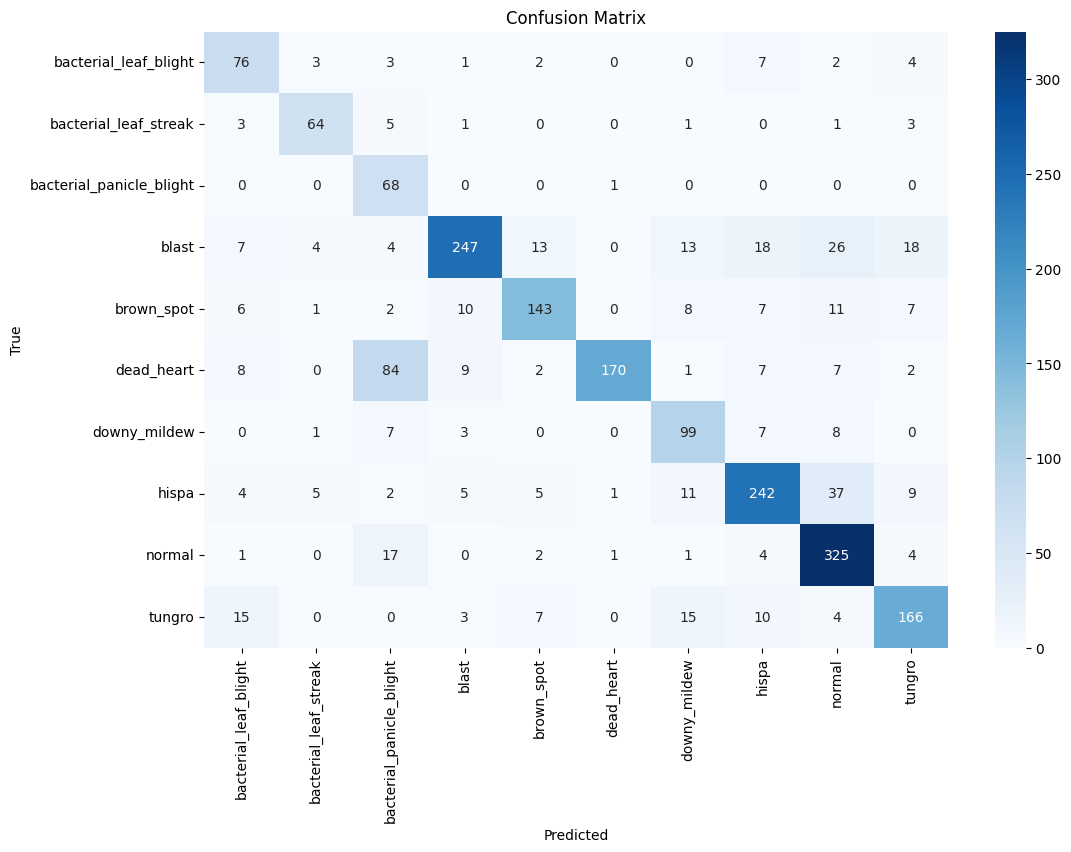

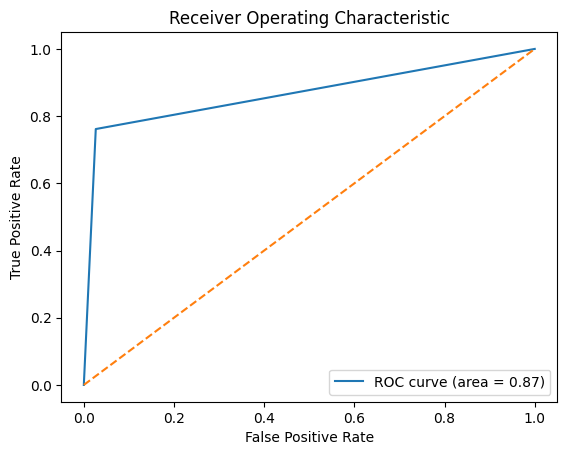

<ipython-input-4-5365e885e6dc>:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Image: 003.jpeg | Disease: brown_spot | Variety: ADT45 | Age: 7022.12 years
Image: BROWNSPOT1_009.jpg | Disease: bacterial_leaf_streak | Variety: Zonal | Age: 6889.24 years
Image: 303.jpeg | Disease: bacterial_leaf_streak | Variety: AndraPonni | Age: 5471.61 years
Image: 504.jpeg | Disease: dead_heart | Variety: ADT45 | Age: 7094.06 years
Image: 100076.jpg | Disease: normal | Variety: ADT45 | Age: 5992.15 years
Image: BROWNSPOT1_001.jpg | Disease: dead_heart | Variety: ADT45 | Age: 7059.22 years
Image: BACTERAILBLIGHT3_013.jpg | Disease: dead_heart | Variety: Ponni | Age: 6172.41 years
Image: 102.jpeg | Disease: bacterial_panicle_blight | Variety: Ponni | Age: 7524.06 years
Image: 101.jpeg | Disease: bacterial_leaf_streak | Variety: RR | Age: 5770.52 years
Image: 207.jpeg | Disease: bacterial_panicle_blight | Variety: ADT45 | Age: 7005.72 years
Image: 404.jpeg | Disease: bacterial_leaf_streak | Variety: Zonal | Age: 5803.88 years
Image: 100003.jpg | Disease: hispa | Variety: AtchayaPon

In [4]:
# === Imports ===
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from timm import create_model
import joblib
import albumentations as A
from albumentations.pytorch import ToTensorV2

# === Paths ===
root_folder = "/kaggle/input/dataset-review-ii/Merged_dataset/train_images"
data = pd.read_csv("/kaggle/input/dataset-review-ii/merged_dataset.csv")

le_disease = LabelEncoder()
le_variety = LabelEncoder()
data['label_idx'] = le_disease.fit_transform(data['label'])
data['variety_idx'] = le_variety.fit_transform(data['variety'])

train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['label_idx'], random_state=42)

# === Transforms ===
albumentations_train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.RGBShift(p=0.3),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(p=0.3)
    ], p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

albumentations_val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

inference_transform = albumentations_val_transform

# === Dataset ===
class PaddyDataset(Dataset):
    def __init__(self, df, transform=None, image_root_dir=root_folder):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_root_dir = image_root_dir
        self.label_to_idx = dict(zip(df['label'], df['label_idx']))
        self.variety_to_idx = dict(zip(df['variety'], df['variety_idx']))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        label = row['label']
        variety = row['variety']
        age = row['age']

        folder_path = os.path.join(self.image_root_dir, label)
        image_path = os.path.join(folder_path, image_id)

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        image = np.array(Image.open(image_path).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']

        label_idx = self.label_to_idx[label]
        variety_idx = self.variety_to_idx[variety]

        return image, torch.tensor(label_idx), torch.tensor(variety_idx), torch.tensor(age, dtype=torch.float32)

train_dataset = PaddyDataset(train_df, albumentations_train_transform)
val_dataset = PaddyDataset(val_df, albumentations_val_transform)

# === Sampler ===
class_sample_counts = train_df['label_idx'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float32)
sample_weights = [class_weights[x] for x in train_df['label_idx']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# === Model ===
base_model = create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
base_model.head = nn.Identity()

class MultiTaskModel(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.backbone = base
        self.dropout = nn.Dropout(0.3)
        self.disease_head = nn.Linear(768, len(le_disease.classes_))
        self.variety_head = nn.Linear(768, len(le_variety.classes_))
        self.age_head = nn.Linear(768, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        return self.disease_head(x), self.variety_head(x), self.age_head(x).squeeze(1)

model = MultiTaskModel(base_model).cuda()

# === Loss, Optimizer, Scheduler ===
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        num_classes = pred.size(1)
        log_probs = nn.functional.log_softmax(pred, dim=1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=1))

loss_fns = {
    'disease': LabelSmoothingCrossEntropy(0.1),
    'variety': nn.CrossEntropyLoss(),
    'age': nn.MSELoss()
}

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# === Training Loop ===
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_acc = 0.0

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels, varieties, ages in tqdm(train_loader):
        images, labels, varieties, ages = images.cuda(), labels.cuda(), varieties.cuda(), ages.cuda()
        optimizer.zero_grad()
        out_disease, out_variety, out_age = model(images)

        loss = (
            loss_fns['disease'](out_disease, labels) +
            loss_fns['variety'](out_variety, varieties) +
            loss_fns['age'](out_age, ages)
        )
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (out_disease.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels, varieties, ages in val_loader:
            images, labels, varieties, ages = images.cuda(), labels.cuda(), varieties.cuda(), ages.cuda()
            out_disease, out_variety, out_age = model(images)
            loss = (
                loss_fns['disease'](out_disease, labels) +
                loss_fns['variety'](out_variety, varieties) +
                loss_fns['age'](out_age, ages)
            )
            val_loss += loss.item()
            val_correct += (out_disease.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(out_disease.argmax(1).cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")

    if val_accuracies[-1] > best_val_acc:
        best_val_acc = val_accuracies[-1]
        torch.save(model.state_dict(), "multitask_vit_model1701.pth")

# === Evaluation ===
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le_disease.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le_disease.classes_, yticklabels=le_disease.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_true_bin = label_binarize(y_true, classes=list(range(len(le_disease.classes_))))
y_pred_scores = np.zeros((len(y_pred), len(le_disease.classes_)))
for i, pred in enumerate(y_pred):
    y_pred_scores[i, pred] = 1.0

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_scores.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# === Inference on Test Images ===
def predict_images_from_folder(model_path, test_folder):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.cuda()

    for image_name in os.listdir(test_folder):
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(test_folder, image_name)
        image = np.array(Image.open(image_path).convert("RGB"))
        image_tensor = inference_transform(image=image)['image'].unsqueeze(0).cuda()
        with torch.no_grad():
            disease_pred, variety_pred, age_pred = model(image_tensor)
            disease = le_disease.inverse_transform([disease_pred.argmax(1).item()])[0]
            variety = le_variety.inverse_transform([variety_pred.argmax(1).item()])[0]
            age = age_pred.item() * 100  # Assuming age was normalized

        print(f"Image: {image_name} | Disease: {disease} | Variety: {variety} | Age: {age:.2f} years")

# Example
predict_images_from_folder("multitask_vit_model1701.pth", "/kaggle/input/test-image")


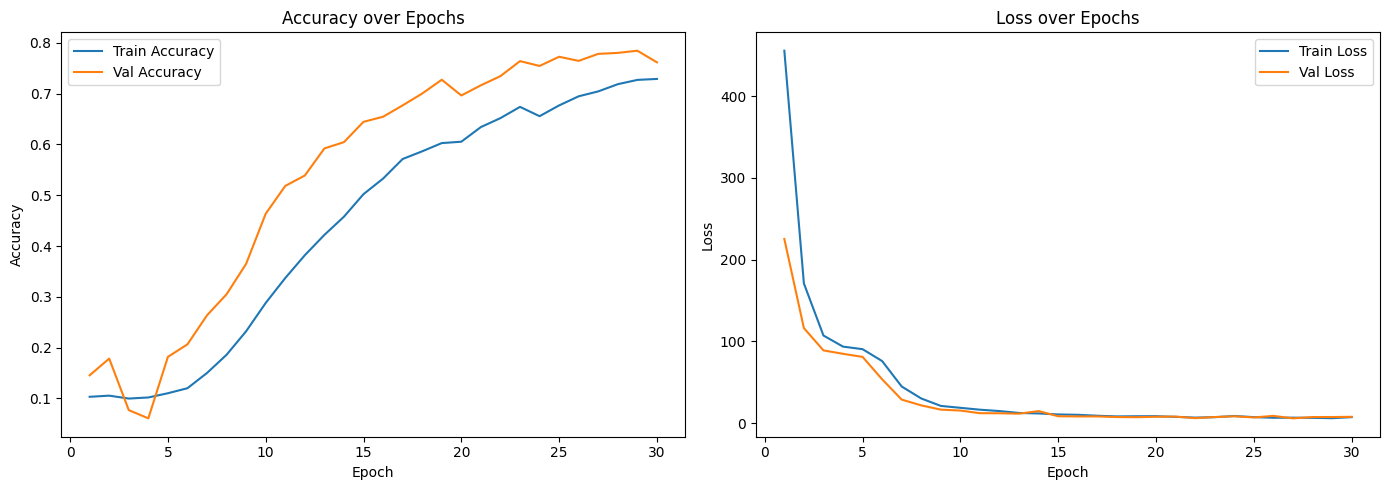

In [5]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
